In [ ]:
import tensorflow as tf
import pandas as pd
import nltk
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn import preprocessing
from nltk.stem import PorterStemmer
from keras.layers import MaxPooling1D
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Conv1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Downloading Dataset**

In [ ]:

df = pd.read_csv('https://github.com/Hsankesara/The-Tweets-of-Wisdom/raw/master/tweets.csv')
print('percent of missing values=',df.isnull().mean().sort_values(ascending=False))
print('authors:',len(df.author_name))
df.dropna(inplace=True)
df.drop(columns=['created_at','likes', 'retweets','handle'],inplace=True)
df.reset_index(inplace=True)
df.drop(columns='index',inplace=True)
df=df.groupby(['author_name']).filter(lambda x : len(x)>50)
print(df['author_name'].value_counts())
print('New shape:',df.shape)
num_of_authors=df['author_name'].value_counts().count()
print("Number of Authors,tweeting more than 50: ",num_of_authors)

percent of missing values= tweet_content    0.011602
author_name      0.000032
retweets         0.000000
likes            0.000000
handle           0.000000
created_at       0.000000
dtype: float64
authors: 31115
Thomas Sowell                            1909
The Ancient Sage                         1678
Orange Book                              1661
Thibaut                                  1314
Krishna                                  1208
seneca                                   1172
LifeMathMoney                            1048
Alexander J.A Cortes                      955
Millstoic                                 915
ChuChuTrain                               885
deep_thrill                               860
Wealth Theory ™                           824
The Stoic Emperor                         817
Michael                                   739
Zen Black                                 736
Ed Latimore                               718
Ralph Napolitano                          710
modes

**Preprocessing**

In [ ]:
for each_item in '?:\/\/(\.)?[-a-z0-9@:%.\+~#=]{1,256}\.[a-z0-9()]{1,6}\b([-a-z0-9()@:%\+.~#?&\/=]*)':
  df.weet_content = df.tweet_content.str.replace(r'{}'.format(each_item), '', regex=True)

df.tweet_content = df.tweet_content.str.replace(r'https', '', regex=True)
df.tweet_content = df.tweet_content.str.replace(r'www', '', regex=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


**Removing Emojis**

In [ ]:
def deEmojify(text):
    regrex_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'',text)

df.author_name= df.author_name.apply(deEmojify)
print(df['author_name'].value_counts())

Thomas Sowell                            1909
The Ancient Sage                         1678
Orange Book                              1661
Thibaut                                  1314
Krishna                                  1208
seneca                                   1172
LifeMathMoney                            1048
Alexander J.A Cortes                      955
Millstoic                                 915
ChuChuTrain                               885
deep_thrill                               860
Wealth Theory ™                           824
The Stoic Emperor                         817
Michael                                   739
Zen Black                                 736
Ed Latimore                               718
Ralph Napolitano                          710
modest proposal                           656
Sahil Lavingia                            642
Uncanny Insights                          611
Paul Graham                               495
Benjamin                          

**Stemming**

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from tqdm.notebook import tqdm
import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer
porter_stemmer=PorterStemmer()
from nltk.tokenize import word_tokenize
documents = []
for tweet in tqdm(df.tweet_content):
  tweet = deEmojify(tweet)
  tweet = word_tokenize(tweet)
  tweet = [porter_stemmer.stem(token) for token in tweet if token not in set(stopwords.words('english'))]
  documents.append(tweet)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Word2vec Model**

In [ ]:
import gensim
from gensim.models import  Word2Vec
model = Word2Vec(sentences=documents, size=30)
model.wv.save_word2vec_format('tweet_embedding_word2vec.txt', binary=False)

**Downloading Glove Pre-trained Model and Unziping**

In [ ]:

!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove*.zip
!ls
!pwd

--2021-07-22 10:32:02--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2021-07-22 10:32:02--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-07-22 10:32:02--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

**Glove Model**

In [ ]:
#Extacting word embedding
embeddings_index_glove= {}
fglove = open('glove.twitter.27B.50d.txt', encoding='utf-8')
for line in fglove:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_glove[word] = coefs
fglove.close()

print('Found %s word vectors.' % len(embeddings_index_glove))

Found 1193514 word vectors.


**Extracting word embedding from tweet_embedding_word2vec.txt**




In [ ]:
print('Indexing word vectors. 30d')

embeddings_index= {}
f = open('tweet_embedding_word2vec.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0] #IndexError: list index out of range
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors. 30d
Found 5701 word vectors.


**Tokenization**

In [ ]:
max_length=0
for i in documents:
  x=len(i) 
  if (x > max_length):
    max_length=x

tknizer = Tokenizer()
tknizer.fit_on_texts(documents)
sequences = tknizer.texts_to_sequences(documents)
sequences = sequence.pad_sequences(sequences,maxlen=max_length, padding='post', value=0)
max_vocab_size=len(tknizer.word_index)+1
items= tknizer.word_index.items()

print("max_vocab_size=",max_vocab_size)
print("max_length=",max_length)

max_vocab_size= 21189
max_length= 128


**Creating a matrix of word vectors from the loaded Glove**

In [ ]:
embedding_matrix_glove = np.zeros((max_vocab_size, 30))
for word, i in items:
  if i> max_vocab_size:
    continue
  embedding_vector_glove = embeddings_index_glove.get(word)
  if embedding_vector_glove is not None:
    embeddings_index_glove[i] = embedding_vector_glove

**Creating a matrix of word vectors from the loaded Word2vec**

In [ ]:
embedding_matrix = np.zeros((max_vocab_size, 30))
for word, i in items:
  if i> max_vocab_size:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
lblcoder = preprocessing.LabelEncoder()
ylabels = lblcoder.fit_transform(df.author_name.values)
print("labels:",ylabels)

labels: [21 21 21 ... 33 33 33]


**Dividing Dataset(80% for trainingset,20% for testset)**

In [ ]:
y=df['author_name']
xtrain, xtest, ytrain, ytest = train_test_split(sequences,ylabels, random_state=42, shuffle=True, test_size=0.2,stratify=y)

In [ ]:
xtrainshape=xtrain.shape[0]
xtestshape=xtest.shape[0]
print("xtrain.shape:",xtrainshape)
print("xtest.shape:",xtestshape)

xtrain.shape: 19468
xtest.shape: 4867


In [ ]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(ytrain, dtype ="uint8")
test_labels = to_categorical(ytest, dtype ="uint8")
num_classes = train_labels.shape[1]
print('There are {} unique authors'.format(num_classes))
print('Shape of the training labels:', train_labels.shape)
print('Shape of the testing labels:', test_labels.shape)
print('An example of the labels:', train_labels[0])

There are 40 unique authors
Shape of the training labels: (19468, 40)
Shape of the testing labels: (4867, 40)
An example of the labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0]


**Bidirectional LSTM(Word2vec)**

In [ ]:
model1 = Sequential()
model1.add(Embedding(max_vocab_size,
 30,
 weights=[embedding_matrix],
 input_length=max_length,
 trainable=False))
model1.add(Bidirectional(LSTM(30, return_sequences=True)))
model1.add(Dropout(0.2))
model1.add(Bidirectional(LSTM(30, return_sequences=True)))
model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(64, activation='relu'))
model1.add(tf.keras.layers.Flatten())
model1.add(Dense(40, activation='softmax'))
xtrain_tf = tf.convert_to_tensor(xtrain[:xtrainshape], np.int32)
xtest_tf = tf.convert_to_tensor(xtest[:xtestshape], np.int32)
ytrain_tf = tf.convert_to_tensor(ytrain[:xtrainshape], np.int32)
ytest_tf = tf.convert_to_tensor(ytest[:xtestshape], np.int32)
model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='nadam', metrics=['accuracy'])
history1_Word2vec = model1.fit(xtrain_tf ,ytrain_tf, batch_size=64, epochs=10, verbose=1, validation_data=(xtest_tf, ytest_tf))
model1.summary()

Epoch 1/10
305/305 [==============================] - 551s 2s/step - loss: 3.0912 - accuracy: 0.1704 - val_loss: 2.8039 - val_accuracy: 0.2246
Epoch 2/10
305/305 [==============================] - 523s 2s/step - loss: 2.5843 - accuracy: 0.2711 - val_loss: 2.6613 - val_accuracy: 0.2696
Epoch 3/10
305/305 [==============================] - 530s 2s/step - loss: 2.4118 - accuracy: 0.3129 - val_loss: 2.4531 - val_accuracy: 0.3057
Epoch 4/10
305/305 [==============================] - 530s 2s/step - loss: 2.2649 - accuracy: 0.3489 - val_loss: 2.4161 - val_accuracy: 0.3158
Epoch 5/10
305/305 [==============================] - 532s 2s/step - loss: 2.1811 - accuracy: 0.3665 - val_loss: 2.4599 - val_accuracy: 0.3053
Epoch 6/10
305/305 [==============================] - 543s 2s/step - loss: 2.0877 - accuracy: 0.3928 - val_loss: 2.3685 - val_accuracy: 0.3316
Epoch 7/10
305/305 [==============================] - 547s 2s/step - loss: 1.9991 - accuracy: 0.4183 - val_loss: 2.4334 - val_accuracy: 0.3261

**Visualizing Model History1 for loss(Word2vec)**

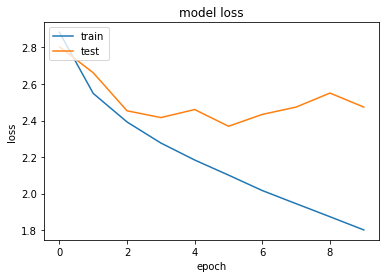

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history1_Word2vec.history['loss'])
plt.plot(history1_Word2vec.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Visualizing Model History1 for accuracy(Word2vec)**


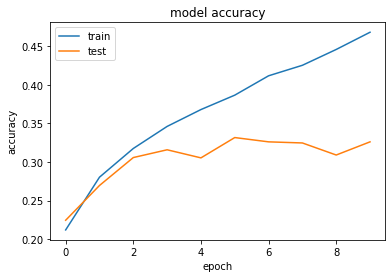

In [ ]:
plt.plot(history1_Word2vec.history['accuracy'])
plt.plot(history1_Word2vec.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**CNN-LSTM joined Model(Word2vec)**

In [ ]:
CNNmodel = Sequential()
CNNmodel.add(Embedding(max_vocab_size,
 30,
 weights=[embedding_matrix],
 input_length=max_length,
 trainable=False))
CNNmodel.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
CNNmodel.add(Bidirectional(LSTM(30, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
CNNmodel.add(Dense(1024, activation='relu'))
CNNmodel.add(Dense(1024, activation='relu'))
CNNmodel.add(tf.keras.layers.Flatten())
CNNmodel.add(Dense(40, activation='softmax'))
CNNmodel.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='nadam', metrics=['accuracy'])
history2_Word2vec = CNNmodel.fit(xtrain_tf ,ytrain_tf, batch_size=64, epochs=10, verbose=1, validation_data=(xtest_tf, ytest_tf))
CNNmodel.summary()

Epoch 1/10
305/305 [==============================] - 423s 1s/step - loss: 3.0873 - accuracy: 0.1675 - val_loss: 2.7295 - val_accuracy: 0.2507
Epoch 2/10
305/305 [==============================] - 386s 1s/step - loss: 2.5358 - accuracy: 0.2848 - val_loss: 2.5464 - val_accuracy: 0.2862
Epoch 3/10
305/305 [==============================] - 381s 1s/step - loss: 2.3148 - accuracy: 0.3330 - val_loss: 2.5874 - val_accuracy: 0.2967
Epoch 4/10
305/305 [==============================] - 384s 1s/step - loss: 2.0959 - accuracy: 0.3856 - val_loss: 2.5631 - val_accuracy: 0.3045
Epoch 5/10
305/305 [==============================] - 383s 1s/step - loss: 1.8688 - accuracy: 0.4467 - val_loss: 2.7065 - val_accuracy: 0.3063
Epoch 6/10
305/305 [==============================] - 382s 1s/step - loss: 1.6728 - accuracy: 0.4999 - val_loss: 2.7884 - val_accuracy: 0.3027
Epoch 7/10
305/305 [==============================] - 387s 1s/step - loss: 1.4612 - accuracy: 0.5560 - val_loss: 2.9312 - val_accuracy: 0.3082

**Visualizing Model History2 for loss(Word2vec)**

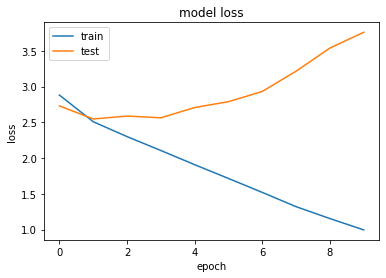

In [ ]:
plt.plot(history2_Word2vec.history['loss'])
plt.plot(history2_Word2vec.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Visualizing Model History2 for accuracy(Word2vec)**


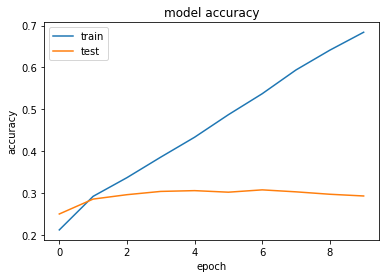

In [ ]:
plt.plot(history2_Word2vec.history['accuracy'])
plt.plot(history2_Word2vec.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Bidirectional LSTM(Glove)**

In [ ]:
model1 = Sequential()
model1.add(Embedding(max_vocab_size,
 30,
 weights=[embedding_matrix_glove],
 input_length=max_length,
 trainable=False))
model1.add(Bidirectional(LSTM(30, return_sequences=True)))
model1.add(Dropout(0.2))
model1.add(Bidirectional(LSTM(30, return_sequences=True)))
model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(64, activation='relu'))
model1.add(tf.keras.layers.Flatten())
model1.add(Dense(40, activation='softmax'))
model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='nadam', metrics=['accuracy'])
history1_glove = model1.fit(xtrain_tf ,ytrain_tf, batch_size=64, epochs=10, verbose=1, validation_data=(xtest_tf, ytest_tf))
model1.summary()

Epoch 1/10
305/305 [==============================] - 563s 2s/step - loss: 3.6562 - accuracy: 0.0610 - val_loss: 3.5688 - val_accuracy: 0.0785
Epoch 2/10
305/305 [==============================] - 544s 2s/step - loss: 3.5461 - accuracy: 0.0741 - val_loss: 3.4946 - val_accuracy: 0.0785
Epoch 3/10
305/305 [==============================] - 545s 2s/step - loss: 3.4821 - accuracy: 0.0772 - val_loss: 3.4488 - val_accuracy: 0.0785
Epoch 4/10
305/305 [==============================] - 545s 2s/step - loss: 3.4427 - accuracy: 0.0778 - val_loss: 3.4213 - val_accuracy: 0.0785
Epoch 5/10
305/305 [==============================] - 552s 2s/step - loss: 3.4203 - accuracy: 0.0761 - val_loss: 3.4048 - val_accuracy: 0.0785
Epoch 6/10
305/305 [==============================] - 539s 2s/step - loss: 3.4047 - accuracy: 0.0758 - val_loss: 3.3949 - val_accuracy: 0.0785
Epoch 7/10
305/305 [==============================] - 530s 2s/step - loss: 3.3907 - accuracy: 0.0813 - val_loss: 3.3888 - val_accuracy: 0.0785

**Visualizing Model History1 for loss(Glove)**

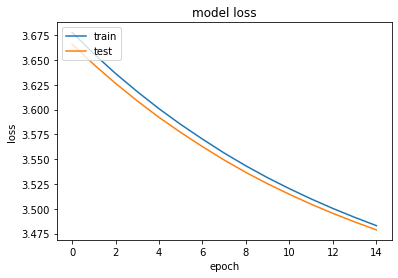

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history1_glove.history['loss'])
plt.plot(history1_glove.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Visualizing Model History1 for accuracy(Glove)**

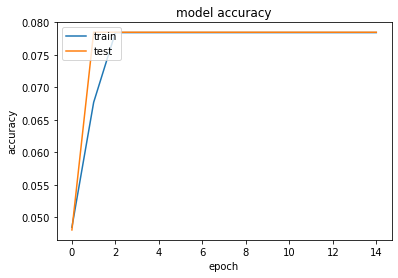

In [ ]:
plt.plot(history1_glove.history['accuracy'])
plt.plot(history1_glove.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**CNN-LSTM joined Model(Glove)**

In [ ]:
CNNmodel = Sequential()
CNNmodel.add(Embedding(max_vocab_size,
 30,
 weights=[embedding_matrix_glove],
 input_length=max_length,
 trainable=False))
CNNmodel.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
CNNmodel.add(Bidirectional(LSTM(30, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
CNNmodel.add(Dense(1024, activation='relu'))
CNNmodel.add(Dense(1024, activation='relu'))
CNNmodel.add(tf.keras.layers.Flatten())
CNNmodel.add(Dense(40, activation='softmax'))
CNNmodel.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='nadam', metrics=['accuracy'])
history2_glove = CNNmodel.fit(xtrain_tf ,ytrain_tf, batch_size=64, epochs=10, verbose=1, validation_data=(xtest_tf, ytest_tf))
CNNmodel.summary()

NameError: ignored

**Visualizing Model History2 for loss(Glove)**

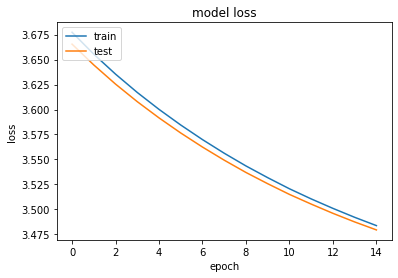

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history2_glove.history['loss'])
plt.plot(history2_glove.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Visualizing Model History2 for accuracy(Glove)**

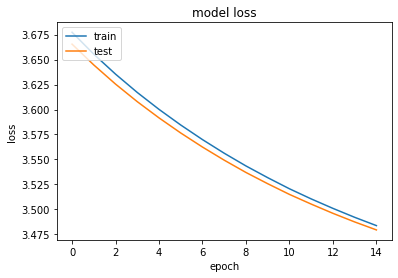

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history2_glove.history['accuracy'])
plt.plot(history2_glove.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()